In [9]:
%matplotlib inline
import os
import sys
import numpy
from pandas import DataFrame
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix, f1_score

def progress(i, end_val, bar_length=50):
    '''
    Print a progress bar of the form: Percent: [#####      ]
    i is the current progress value expected in a range [0..end_val]
    bar_length is the width of the progress bar on the screen.
    '''
    percent = float(i) / end_val
    hashes = '#' * int(round(percent * bar_length))
    spaces = ' ' * (bar_length - len(hashes))
    sys.stdout.write("\rPercent: [{0}] {1}%".format(hashes + spaces, int(round(percent * 100))))
    sys.stdout.flush()

NEWLINE = '\n'

In [10]:
HAM = 'ham'
SPAM = 'spam'

SOURCES = [
    ('data/spam',        SPAM),
    ('data/easy_ham',    HAM),
    ('data/hard_ham',    HAM),
    ('data/beck-s',      HAM),
    ('data/farmer-d',    HAM),
    ('data/kaminski-v',  HAM),
    ('data/kitchen-l',   HAM),
    ('data/lokay-m',     HAM),
    ('data/williams-w3', HAM),
    ('data/BG',          SPAM),
    ('data/GP',          SPAM),
    ('data/SH',          SPAM)
]

SKIP_FILES = {'cmds'}


def read_files(path):
    '''
    Generator of pairs (filename, filecontent)
    for all files below path whose name is not in SKIP_FILES.
    The content of the file is of the form:
        header....
        <emptyline>
        body...
    This skips the headers and returns body only.
    '''
    for root, dir_names, file_names in os.walk(path):
        for path in dir_names:
            read_files(os.path.join(root, path))
        for file_name in file_names:
            if file_name not in SKIP_FILES:
                file_path = os.path.join(root, file_name)
                if os.path.isfile(file_path):
                    past_header, lines = False, []
                    f = open(file_path, encoding="latin-1")
                    for line in f:
                        if past_header:
                            lines.append(line)
                        elif line == NEWLINE:
                            past_header = True
                    f.close()
                    content = NEWLINE.join(lines)
                    yield file_path, content


def build_data_frame(l, path, classification):
    rows = []
    index = []
    for i, (file_name, text) in enumerate(read_files(path)):
        if ((i+l) % 100 == 0):
            progress(i+l, 58910, 50)
        rows.append({'text': text, 'class': classification})
        index.append(file_name)
   
    data_frame = DataFrame(rows, index=index)
    return data_frame, len(rows)

def load_data():
    data = DataFrame({'text': [], 'class': []})
    l = 0
    for path, classification in SOURCES:
        data_frame, nrows = build_data_frame(l, path, classification)
        data = data.append(data_frame)
        l += nrows
    data = data.reindex(numpy.random.permutation(data.index))
    return data

In [11]:
data=load_data()


Percent: [##                                                ] 4%

D:\Anacondda\a\lib\site-packages\pandas\core\frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


Percent: [##################################################] 100%

# Now Data is ready 

In [12]:
data.head()

,class,text
data/BG\2005\03\1111378896.310_102.txt,spam,"<table border=0 width=""100%"" cellpadding=""8"" ..."
data/BG\2004\08\1091639672.6258_79.txt,spam,----2812957960422\n\nContent-Type: text/plain;...
data/GP\part12\msg3973.eml,spam,"<HTML><FONT SIZE=3D2 PTSIZE=3D10 FAMILY=3D""SA..."
data/SH\HP\prodmsg.2.446094.2005717,spam,This is a MIME-encapsulated message\n\n\n\n--j...
data/williams-w3\bill_williams_iii\485,ham,"Bill,\n\n\n\nThese are currently being tested ..."


Let's Check the size of data

In [13]:
len(data)


58910

# The above data is only of spam and ham emails but for SMS we will need a message dataset also

In [14]:
import pandas as pd
datasms=pd.read_csv('SMSSpamCollection.csv')

In [15]:
datasms.head()

,class,text,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12,Unnamed: 13
0,ham,Go until jurong point,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,ham,Nah I don't think he goes to usf,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


But the sms data is not cleaned so we will remve this nan values

In [16]:
len(datasms)
datasms.describe()


,class,text,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12,Unnamed: 13
count,5574,5570,369,141,62,40,22,8,6,2,2,1,1,1
unique,2,4967,310,108,40,26,12,7,6,2,2,1,1,1
top,ham,Sorry,POBox334,Stockport,SK38xh,Cost£1.50/pm,Max10mins,Make a strike against it ...,about... Up to u! Wot about ?,but when you don't make the bed,when you throw laundry on top of it,when i can't have a friend in the house becau...,pillows on the floor,that's something else. You used to be good ab...
freq,4827,52,6,6,6,6,6,2,1,1,1,1,1,1


(1)First column of dataset contains labels ham or spam                                                  
(2)Second column contain the text                                           
(3)There are total 5574 Sms out of which 4827 are ham and 747 spam                                         
Count of spam sms data is very less                               

In [17]:
datasms=datasms.iloc[:,0:2]

In [18]:
datasms.describe()

,class,text
count,5574,5570
unique,2,4967
top,ham,Sorry
freq,4827,52


still the dataset is not completely clean it contains null or nan values.              
Further processing or cleaning of data is finding those null values and deleting them

In [19]:
datasms.head()

,class,text
0,ham,Go until jurong point
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,Nah I don't think he goes to usf


In [20]:
import numpy as np
np.where(np.asanyarray(pd.isnull(datasms)))


(array([3475, 4006, 4387, 5486], dtype=int64),
 array([1, 1, 1, 1], dtype=int64))

In [21]:
datasms=datasms.drop([3475,4006,4387,5486],axis=0)

np.where--> To find the location                                              
np.asanyarray----> Convert the input to an ndarray                                     
pd.isnull---> to find the null values in your data set                   
We got the index of the values like[3475th row and 1st column] 

Our email dataset doesn't have the proper index.                          
Resetting the data index same as datasms i.e 0,1,2,3,4...upto the length of data

In [23]:
new_index=[x for x in range(len(data))]
data.index=new_index

In [24]:
datasms.head()

,class,text
0,ham,Go until jurong point
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,Nah I don't think he goes to usf


In [25]:
data.head()

,class,text
0,spam,"<table border=0 width=""100%"" cellpadding=""8"" ..."
1,spam,----2812957960422\n\nContent-Type: text/plain;...
2,spam,"<HTML><FONT SIZE=3D2 PTSIZE=3D10 FAMILY=3D""SA..."
3,spam,This is a MIME-encapsulated message\n\n\n\n--j...
4,ham,"Bill,\n\n\n\nThese are currently being tested ..."


In [26]:
data.shape

(58910, 2)

Now we will merge both the dataset .i.e("EMAIL and SMS") and perform our training on combined dataset

In [27]:
data=data.append(datasms)

In [28]:
data.shape

(64480, 2)

In [24]:
data.head()

,class,text
0,spam,"<!DOCTYPE HTML PUBLIC ""-//W3C//DTD HTML 4.0 Tr..."
1,ham,Attached please find March's curve validation ...
2,ham,"Vince,\n\nIt was a pleasure to meet you last w..."
3,ham,(See attached file: HPLN1103.xls)\n\n\n\n - HP...
4,ham,Attached are the Year-to-date closed deals thr...


In [25]:
def token_count(row):
    'returns token count'
    text=row['tokenized_text']
    length=len(text.split())
    return length

def tokenize(row):
    "tokenize the text using default space tokenizer"
    text=row['text']
    lines=(line for line in text.split(NEWLINE) )
    tokenized=""
    for sentence in lines:
        tokenized+= " ".join(tok for tok in sentence.split())
    return tokenized

# Tokenize function
(1)It takes the row from dataset one by one using apply function                          
(2)next the dext is extracted from text column and stored in text variable                       
(3)It is splited based on newline .                                       
(4)whole message is in one line now but in 

In [26]:
#data.iloc[4006]

In [27]:
#data.iloc[0]

In [28]:
data['tokenized_text']=data.apply(tokenize, axis=1)


In [29]:
data['token_count']=data.apply(token_count, axis=1)


In [30]:
data.columns

Index(['class', 'text', 'tokenized_text', 'token_count'], dtype='object')

In [31]:
data.columns=['label', 'text', 'tokenized_text', 'token_count']

In [32]:
#set(data.label)

In [33]:
df=data
print("total emails : ", len(df))
print  ("total spam emails : ", len(df[df['label']=='spam']) )
print  ("total normal emails : ", len(df[df['label']=='ham']) )

total emails :  64480
total spam emails :  36118
total normal emails :  28362


In [34]:
import numpy as np
df.reset_index(inplace=True)
df=df.reindex(np.random.permutation(df.index))

In [38]:
df.head()

,index,label,text,tokenized_text,token_count
9453,9453,ham,"Louise,\n\nThe multiples have been updated.\n\...","Louise,The multiples have been updated.Thanks,...",5
26770,26770,spam,"Saludos <p><!DOCTYPE HTML PUBLIC ""-//W3C//DTD...","Saludos <p><!DOCTYPE HTML PUBLIC ""-//W3C//DTD ...",734
25220,25220,ham,Louise:\n\n\n\nI am NOT taking the P/L swings ...,Louise:I am NOT taking the P/L swings or fundi...,93
44912,44912,ham,"Nick,\n\n\n\nWe may have problems getting the ...","Nick,We may have problems getting the VC locat...",132
54820,54820,spam,"<!DOCTYPE HTML PUBLIC ""-//W3C//DTD HTML 3.2//E...","<!DOCTYPE HTML PUBLIC ""-//W3C//DTD HTML 3.2//E...",150


In [36]:
len_unseen=10000
df_unseen_test= df.iloc[:len_unseen]
df_model = df.iloc[len_unseen:]

print('total emails for unseen test data : ', len(df_unseen_test))
print('\t total spam emails for enron  : ', len(df_unseen_test[(df_unseen_test['label']=='spam')]))
print('\t total normal emails for enron  : ', len(df_unseen_test[ (df_unseen_test['label']=='ham')]))
print()

print('total emails for model training/validation : ', len(df_model))
print('\t total spam emails for enron  : ', len(df_model[(df_model['label']=='spam')]))
print('\t total normal emails for enron  : ', len(df_model[ (df_model['label']=='ham')]))

total emails for unseen test data :  10000
	 total spam emails for enron  :  5590
	 total normal emails for enron  :  4410

total emails for model training/validation :  54480
	 total spam emails for enron  :  30528
	 total normal emails for enron  :  23952


In [37]:
import keras

from keras.layers import Input, Dense
from keras.models import Model,load_model
from keras.layers import Input, Dense
from keras.models import Model
from keras import regularizers

from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.callbacks import ModelCheckpoint, TensorBoard
import sklearn
from sklearn import metrics
from sklearn import svm
from sklearn.externals import joblib
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf

Using TensorFlow backend.


In [39]:
num_max = 4000
import time

In [40]:
def train_tf_idf_model(texts):
    "train tf idf model "
    tic = time.process_time()
    

    tok = Tokenizer(num_words=num_max)
    tok.fit_on_texts(texts)
    print(list(tok.word_index.values())[0])
    toc = time.process_time()

    print (" -----total Computation time = " + str((toc - tic)) + " seconds")
    return tok


def prepare_model_input(tfidf_model,dataframe,mode='tfidf'):
    
    "function to prepare data input features using tfidf model"
    tic = time.process_time()
    
    le = LabelEncoder()
    sample_texts = list(dataframe['tokenized_text'])
    sample_texts = [' '.join(x.split()) for x in sample_texts]
    print("conversion : ",sample_texts[:1])
    
    targets=list(dataframe['label'])
    targets = [1. if x=='spam' else 0. for x in targets]
    sample_target = le.fit_transform(targets)
    
    if mode=='tfidf':
        sample_texts=tfidf_model.texts_to_matrix(sample_texts,mode='tfidf')
    else:
        sample_texts=tfidf_model.texts_to_matrix(sample_texts)
    
    print("after tfidf : ",sample_texts[:1])
    toc = time.process_time()
    
    print('shape of labels: ', sample_target.shape)
    print('shape of data: ', sample_texts.shape)
    
    print (" -----total Computation time for preparing model data = " + str((toc - tic)) + " seconds")
    
    #return sample_texts
    return sample_texts,sample_target

In [41]:
texts=list(df_model['tokenized_text'])
tfidf_model=train_tf_idf_model(texts)

1
 -----total Computation time = 14.78125 seconds


In [42]:
tfidf_model

In [43]:
mat_texts,tags=prepare_model_input(tfidf_model,df_model,mode='tfidf')


conversion :  ['<html><body text=3D"#FFFFFF" bgcolor=3D"#FFFFFF" link=3D"#FF0000" =vlink=3D"#FF0000" alink=3D"#00CC00">=20<center><table BORDER=3D0 CELLSPACING=3D0 COLS=3D1 WIDTH=3D"80%" ><tr><td><font face=3D"Verdana" size=3D"-1"><font color=3D"#3333FF">As =seen on NBC,=20CBS, and CNN, and even Oprah!</font><font color=3D"#000000"> The =health</font></font>=20<br><font face=3D"Verdana" color=3D"#000000" size=3D"-1">discovery =that actually=20rev</aol>erses ag</aol>ing while bur</aol>ning f</aol>at,</font> =<br><font face=3D"Verdana" color=3D"#000000" size=3D"-1">without =dieting or exercise!=20This proven dis</aol>covery has even</font> <br><font face=3D"Verdana" color=3D"#000000" size=3D"-1">been =rep</aol>orted on by major=20Sci</aol>ence Jou</aol>rnals.</font> <br><font face=3D"Verdana" size=3D"-1"><font =color=3D"#000000">Fo</aol>rget a</aol>ging and=20di</aol>eting fo</aol>rever! </font><font color=3D"#3366FF">And =It\'s Gua</aol>ranteed!</font></font>=20<br>=20<p><font face=3D"V

In [44]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(mat_texts, tags, test_size=0.15)
print ('train data shape: ', X_train.shape, y_train.shape)
print ('validation data shape :' , X_val.shape, y_val.shape)

train data shape:  (46308, 4000) (46308,)
validation data shape : (8172, 4000) (8172,)


In [45]:
model_save_path="checkpoints/spam_detector_enron_model.h5"


In [46]:
import tensorflow as tf

In [60]:
def get_simple_model():
    model = Sequential()
    model.add(Dense(512, activation='relu', input_shape=(num_max,)))
    model.add(Dropout(0.5))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    model.summary()
    model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['acc',keras.metrics.binary_accuracy])
    print('compile done')
    return model

def check_model(model,x,y,epochs=2):
    history=model.fit(x,y,batch_size=32,epochs=epochs,verbose=1,shuffle=True,validation_split=0.2,
              callbacks=[checkpointer, tensorboard]).history
    return history


def check_model2(model,x_train,y_train,x_val,y_val,epochs=4):
    history=model.fit(x_train,y_train,batch_size=64,
                      epochs=epochs,verbose=1,
                      shuffle=True,
                    validation_data=(x_val, y_val),
                      callbacks=[checkpointer, tensorboard]).history
    frozen_graph = freeze_session(keras.backend.get_session(), output_names=[out.op.name for out in model.outputs])
    tf.train.write_graph(frozen_graph, './', 'xor.pbtxt', as_text=True)
    tf.train.write_graph(frozen_graph, './', 'xor.pb', as_text=False)
    return history

# define checkpointer
checkpointer = ModelCheckpoint(filepath=model_save_path,
                               verbose=1,
                               save_best_only=True)    


# define tensorboard
tensorboard = TensorBoard(log_dir='./logs',
                          histogram_freq=0,
                          write_graph=True,
                          write_images=True)

def freeze_session(session, keep_var_names=None, output_names=None, clear_devices=True):
    """
    Freezes the state of a session into a pruned computation graph.

    Creates a new computation graph where variable nodes are replaced by
    constants taking their current value in the session. The new graph will be
    pruned so subgraphs that are not necessary to compute the requested
    outputs are removed.
    @param session The TensorFlow session to be frozen.
    @param keep_var_names A list of variable names that should not be frozen,
                          or None to freeze all the variables in the graph.
    @param output_names Names of the relevant graph outputs.
    @param clear_devices Remove the device directives from the graph for better portability.
    @return The frozen graph definition.
    """
    graph = session.graph
    with graph.as_default():
        freeze_var_names = list(set(v.op.name for v in tf.global_variables()).difference(keep_var_names or []))
        output_names = output_names or []
        output_names += [v.op.name for v in tf.global_variables()]
        input_graph_def = graph.as_graph_def()
        if clear_devices:
            for node in input_graph_def.node:
                node.device = ""
        frozen_graph = tf.graph_util.convert_variables_to_constants(
            session, input_graph_def, output_names, freeze_var_names)
        return frozen_graph
from keras import backend as K

# Create, compile and train model...



# define the predict function for the deep learning model for later use
def predict(data):
    result=spam_model_dl.predict(data)
    prediction = [round(x[0]) for x in result]
    return prediction

In [70]:
model = get_simple_model()
#    history=model.fit(x_train,y_train,batch_size=64,
#   epochs=epochs,verbose=1,shuffle=True,validation_data=(x_val, y_val),callbacks=[checkpointer, tensorboard]).history

# load history
# history=check_model(m,mat_texts,tags,epochs=10)
history=check_model2(model,X_train,y_train,X_val,y_val,epochs=24)



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_19 (Dense)             (None, 512)               2048512   
_________________________________________________________________
dropout_13 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_20 (Dense)             (None, 256)               131328    
_________________________________________________________________
dropout_14 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_21 (Dense)             (None, 1)                 257       
Total params: 2,180,097
Trainable params: 2,180,097
Non-trainable params: 0
_________________________________________________________________
compile done
Train on 46308 samples, validate on 8172 samples
Epoch 1/24
46308/46308 [==============================] - 7s 160us/ste

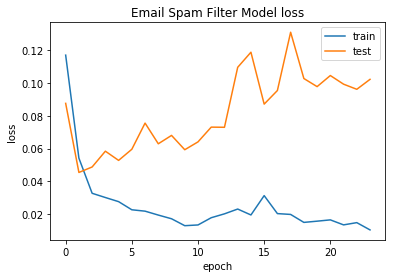

In [71]:
import matplotlib.pyplot as plt
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('Email Spam Filter Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right');

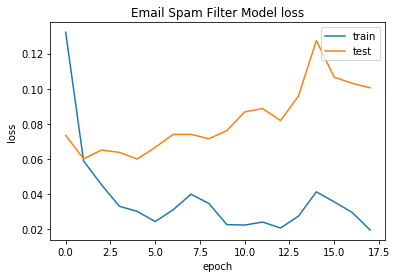

In [58]:
import matplotlib.pyplot as plt
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('Email Spam Filter Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right');

In [59]:
import matplotlib.pyplot as plt
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('Email Spam Filter Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right');

TypeError: 'History' object is not subscriptable

In [64]:
sample_texts,sample_target=prepare_model_input(tfidf_model,df_unseen_test,mode='')

conversion :  ['The memo distributed on June 27 on Reimbursement of Individually Billed Itemsrequiresclarification. The intent of the memo was to give employees an alternatemethodof paying for pagers, cell phones, etc. Employees can continue to submittheseinvoices to Accounts Payable for processing or pay these items with theircorporateAmerican Express card and request reimbursement through an expense report.Eitherway is an acceptable way to process these small dollar high volume invoices.']
after tfidf :  [[0. 0. 0. ... 0. 0. 0.]]
shape of labels:  (10000,)
shape of data:  (10000, 4000)
 -----total Computation time for preparing model data = 9.125 seconds


ValueError: too many values to unpack (expected 2)

In [66]:
df_unseen_test

,index,label,text,tokenized_text,token_count
49555,49555,ham,The memo distributed on June 27 on Reimburseme...,The memo distributed on June 27 on Reimburseme...,66
38491,38491,spam,"<html>\n\n<head>\n\n</head>\n\n<body bgcolor=""...","<html><head></head><body bgcolor=""#FFFFFF""><b>...",47
62332,3422,spam,Welcome! Please reply with your AGE and GENDER...,Welcome! Please reply with your AGE and GENDER...,12
53677,53677,spam,\n\n<html>\n\n</head>\n\n<body>\n\n<p align=3D...,"<html></head><body><p align=3D""center""><a =hre...",19
32396,32396,ham,I am confused. What file do you want me to upd...,I am confused. What file do you want me to upd...,152
26939,26939,spam,This is a multi-part message in MIME format\n\...,This is a multi-part message in MIME format--=...,688
57214,57214,ham,"Sally, \n\n\n\nThanks for calling last night.\...","Sally,Thanks for calling last night.I've spoke...",153
6052,6052,ham,"Steve,\n\n\n\nI spoke with David ealier today....","Steve,I spoke with David ealier today. He is p...",287
33789,33789,ham,\n\n\n\nStart Date: 1/29/02; HourAhead hour: 9...,Start Date: 1/29/02; HourAhead hour: 9; No anc...,20
1986,1986,spam,The Oi| and Gas Advisory\n\nNow that Oi| and G...,The Oi| and Gas AdvisoryNow that Oi| and Gas h...,895


In [83]:
test=pd.read_csv("Test.csv")

In [84]:
test['tokenized_text']=test.apply(tokenize, axis=1)

In [85]:
test['token_count']=test.apply(token_count, axis=1)


In [86]:
test.columns=['label', 'text', 'tokenized_text', 'token_count']

In [87]:
test.tokenized_text[1]

'SBIDrCArd X8091 used for rs 57 on 31 jul19 at 96081575 txn#921207889385'

In [88]:
# prepare model input data
mat_texts_test,tags_test=prepare_model_input(tfidf_model,test,mode='')

conversion :  ['1 Day FREE SHOPPING']
after tfidf :  [[0. 0. 0. ... 0. 0. 0.]]
shape of labels:  (9,)
shape of data:  (9, 4000)
 -----total Computation time for preparing model data = 0.015625 seconds


In [79]:
model.predict(mat_texts_test)

array([[7.46625543e-01],
       [1.21445955e-04],
       [1.00000000e+00],
       [3.81225686e-06],
       [1.97782174e-06],
       [8.43413830e-01],
       [1.49846837e-08],
       [4.27574933e-01],
       [4.37368304e-01]], dtype=float32)

In [89]:
test

,label,text,tokenized_text,token_count
0,spam,1 Day FREE SHOPPING\n,1 Day FREE SHOPPING,4
1,ham,SBIDrCArd X8091 used for rs 57 on 31 jul19 at ...,SBIDrCArd X8091 used for rs 57 on 31 jul19 at ...,12
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,Free entry in 2 a wkly comp to win FA Cup fina...,28
3,spam,I HAVE A DATE ON SUNDAY WITH WILL!!,I HAVE A DATE ON SUNDAY WITH WILL!!,8
4,asuh,Magic Monday! Use Code Make30 and get rs 30 ca...,Magic Monday! Use Code Make30 and get rs 30 ca...,16
5,asb,0% Processing fee & no hidden charges for pers...,0% Processing fee & no hidden charges for pers...,10
6,not,"Dear Akash,\n \nWe understand your disappointm...","Dear Akash,We understand your disappointment.W...",42
7,asdj,"Avail exculsive offers discount at tatacliq,bi...","Avail exculsive offers discount at tatacliq,bi...",6
8,sadhu,Apply for lifetime free* membership of america...,Apply for lifetime free* membership of america...,10


In [56]:
model.predict(mat_texts_test)

array([[0.28647274],
       [0.05415099],
       [0.9886863 ],
       [0.01717733],
       [0.08789813],
       [0.22078027],
       [0.02512039],
       [0.33109105],
       [0.58583325]], dtype=float32)

In [61]:
np.around(model.predict(mat_texts_test))

array([[1.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [1.]], dtype=float32)

In [69]:
np.around(model.predict(mat_texts_test))

array([[1.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.]], dtype=float32)

In [82]:
model.predict(mat_texts_test)

array([[7.46625543e-01],
       [1.21445955e-04],
       [1.00000000e+00],
       [3.81225686e-06],
       [1.97782174e-06],
       [8.43413830e-01],
       [1.49846837e-08],
       [4.27574933e-01],
       [4.37368304e-01]], dtype=float32)

In [92]:
np.around(model.predict(mat_texts_test))

array([[1.],
       [0.],
       [1.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.]], dtype=float32)